In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Prepare the dataset

In [16]:
# Load the data
df = pd.read_csv('../product_details.csv')
df

,ProductID,Description,Country,Category
0,23183,MOTHER'S KITCHEN SPOON REST,United Kingdom,Dapur
1,82578,KITCHEN METAL SIGN,United Kingdom,Dapur
2,47567,TEA TIME KITCHEN APRON,Portugal,Dapur
3,22624,IVORY KITCHEN SCALES,United Kingdom,Dapur
4,22625,RED KITCHEN SCALES,United Kingdom,Dapur
...,...,...,...,...
175,21995,Fujifilm Finepix 30i,United Kingdom,Kamera
176,21996,Fujifilm FinePix 3800,Norway,Kamera
177,21997,Fujifilm FinePix F10 Zoom,United Kingdom,Kamera
178,21998,Fujifilm FinePix F410 Zoom,United Kingdom,Kamera


In [17]:
# Dataset information
print("There are {} rows and {} columns".format(df.shape[0],df.shape[1]))
print("\n====================================================")
print("Missing Values:\n", df.isnull().sum())
print("\n====================================================")
print("Categories Counts:\n", df['Category'].value_counts())

There are 180 rows and 4 columns

Missing Values:
 ProductID      0
Description    0
Country        0
Category       0
dtype: int64

Categories Counts:
 Dapur           20
Cafe            20
Hobi            20
Elektronik      20
Travel          20
Baju            20
Musik           20
Transportasi    20
Kamera          20
Name: Category, dtype: int64


In [18]:
# Mapping the labels to numeric
df['Category'] = df['Category'].map({
    'Dapur': 0,
    'Cafe': 1,
    'Hobi': 2,
    'Elektronik': 3,
    'Travel': 4,
    'Baju': 5,
    'Musik': 6,
    'Transportasi': 7,
    'Kamera': 8
})

df

,ProductID,Description,Country,Category
0,23183,MOTHER'S KITCHEN SPOON REST,United Kingdom,0
1,82578,KITCHEN METAL SIGN,United Kingdom,0
2,47567,TEA TIME KITCHEN APRON,Portugal,0
3,22624,IVORY KITCHEN SCALES,United Kingdom,0
4,22625,RED KITCHEN SCALES,United Kingdom,0
...,...,...,...,...
175,21995,Fujifilm Finepix 30i,United Kingdom,8
176,21996,Fujifilm FinePix 3800,Norway,8
177,21997,Fujifilm FinePix F10 Zoom,United Kingdom,8
178,21998,Fujifilm FinePix F410 Zoom,United Kingdom,8


In [19]:
# Change the labels to multi-labels
y = tf.keras.utils.to_categorical(df['Category'].values, num_classes=9)

# Split the dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df['Description'], y, test_size=0.2, random_state=24)

# Preprocessing the text

In [20]:
# Preprocessing the text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [21]:
# Set the word index
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(len(word_index))
print(word_index)

465
{'<OOV>': 1, 'kitchen': 2, 'coffee': 3, 'black': 4, 'bike': 5, 'red': 6, 'blue': 7, 'set': 8, 'mug': 9, 'garden': 10, 'mountain': 11, 'with': 12, 'fujifilm': 13, 'silver': 14, 'women': 15, 'white': 16, 'guitar': 17, 'finepix': 18, 'yamaha': 19, 'canon': 20, 'box': 21, 'design': 22, 'fit': 23, 'casual': 24, 'shirt': 25, 'mini': 26, 'clock': 27, 'fashion': 28, 'powershot': 29, 'hd': 30, 'small': 31, 'men': 32, 'regular': 33, '2': 34, 'warmer': 35, 'vintage': 36, 'retrospot': 37, 'piano': 38, 'tv': 39, 'flower': 40, '3': 41, 'ivory': 42, '200': 43, '100': 44, 'retro': 45, 'wall': 46, 'pink': 47, 'neck': 48, 'scales': 49, 'rain': 50, 'electric': 51, 'wire': 52, 'hand': 53, 'smart': 54, 'alexa': 55, 'kit': 56, 'battery': 57, 'summer': 58, 'slipper': 59, '4k': 60, 'model': 61, 'tea': 62, 'pots': 63, 'plaque': 64, 'casio': 65, 'exilim': 66, 'ex': 67, 'chevrolet': 68, 'bass': 69, '46': 70, 'campus': 71, 'sutra': 72, 'checked': 73, 'backpack': 74, 'for': 75, 'metal': 76, 'sign': 77, 'made':

In [22]:
# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(X_train)
maxlen = max([len(x) for x in sequences])
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [23]:
# Generate and pad the test sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

# Build the model

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics='accuracy')

# Set callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("val_accuracy") > 0.99):
            self.model.stop_training = True

# Summary of the model
model.summary()

# Train the model
history = model.fit(padded, Y_train, validation_data=(test_padded, Y_test), callbacks=myCallback(), epochs=200)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 64)            29824     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               33280     
                                                                 
 dense_3 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 67,721
Trainable params: 67,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5/5 [==============================] - 1s 75ms/step - loss: 2.1983 - accuracy: 0.0903 - val_loss: 2.1909

Epoch 52/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0402 - accuracy: 1.0000 - val_loss: 0.3954 - val_accuracy: 0.9722
Epoch 53/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0372 - accuracy: 1.0000 - val_loss: 0.3918 - val_accuracy: 0.9722
Epoch 54/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.3878 - val_accuracy: 0.9722
Epoch 55/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.3809 - val_accuracy: 0.9722
Epoch 56/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.3749 - val_accuracy: 0.9722
Epoch 57/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.3698 - val_accuracy: 0.9722
Epoch 58/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.3648 - val_accuracy: 0.9722
Epoch 59/200


5/5 [==============================] - 0s 25ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2647 - val_accuracy: 0.9722
Epoch 111/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2653 - val_accuracy: 0.9722
Epoch 112/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2656 - val_accuracy: 0.9722
Epoch 113/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2647 - val_accuracy: 0.9722
Epoch 114/200
5/5 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.2634 - val_accuracy: 0.9722
Epoch 115/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2623 - val_accuracy: 0.9722
Epoch 116/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2611 - val_accuracy: 0.9722
Epoch 117/200
5/5 [=

Epoch 168/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2346 - val_accuracy: 0.9722
Epoch 169/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2340 - val_accuracy: 0.9722
Epoch 170/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2336 - val_accuracy: 0.9722
Epoch 171/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2330 - val_accuracy: 0.9722
Epoch 172/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2325 - val_accuracy: 0.9722
Epoch 173/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9722
Epoch 174/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2322 - val_accuracy: 0.9722
Epoch 

# Evaluate the model

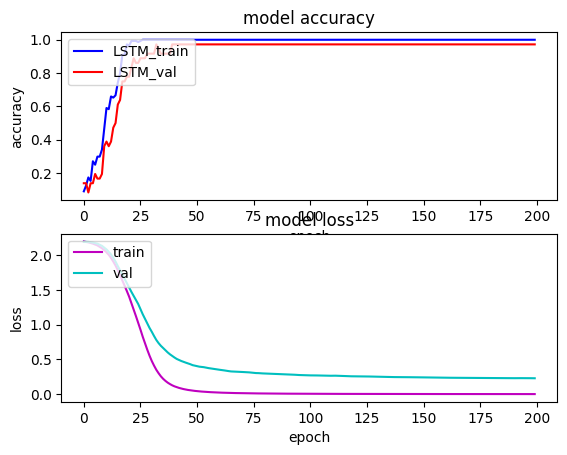

In [33]:
import matplotlib.pyplot as plt

s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [26]:
# Test the prediction with test set
scores = model.predict(test_padded).round()
print(scores)

2/2 [==============================] - 0s 4ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n\n",confusion_matrix(Y_test.argmax(axis=1),scores.argmax(axis=1)))
print("\n")
print("Classification Report:\n\n",classification_report(Y_test.argmax(axis=1), scores.argmax(axis=1)))

Confusion Matrix:

 [[5 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0]
 [2 0 2 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 2 0 0]
 [2 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 5]]


Classification Report:

               precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         2
           7       1.00      0.33      0.50         3
           8       1.00      1.00      1.00         5

    accuracy                           0.89        36
   macro avg       0.95      0.87      0.88        36
weighted avg       0.94      0.89      0.88        36



# Test the model's prediction

In [28]:
# Define a function for preprocessing input

def ubah_text(text):
    text_to_list = [text]
    sequences = tokenizer.texts_to_sequences(text_to_list)
    maxlen = max([len(x) for x in sequences])
    padded = pad_sequences(sequences, maxlen=21, padding='post', truncating='post')
    
    return padded

In [31]:
# Test the prediction with text input
text = "Lenovo Laptop, IdeaPad , AMD Athlon Dual-core Processor, Wi-Fi 6 and Bluetooth"
preprocessed_text = ubah_text(text)
print(preprocessed_text)

[[  1   1   1   1   1   1   1   1   1   1 338 206   1   0   0   0   0   0
    0   0   0]]


In [32]:
coba  = model.predict(preprocessed_text)
if coba.argmax() == [0]:
    coba = "Dapur"
elif coba.argmax() == [1]:
    coba = "Kafe"
elif coba.argmax() == [2]:
    coba = "Hobi"
elif coba.argmax() == [3]:
    coba = "Elektronik"
elif coba.argmax() == [4]:
    coba = "Travel"
elif coba.argmax() == [5]:
    coba = "Baju"
elif coba.argmax() == [6]:
    coba = "Musik"
elif coba.argmax() == [7]:
    coba = "Transportasi"
elif coba.argmax() == [8]:
    coba = "Kamera"
print(coba)

1/1 [==============================] - 0s 26ms/step
Elektronik


# Save the model

In [25]:
# Save the model
import pickle

pickle.dump(model, open('model_tf.pkl', 'wb'))
pickle.dump(X_train, open("X_train.pkl", "wb"))